# Giới thiệu

### Mục tiêu bài tập

* Hiểu thêm về cách hoạt động của Numpy và Tensorflow 
* Có thể viết một thuật toán đơn giản (và debug) với `Tensorflow` và `Numpy` qua ví dụ về hồi quy tuyến tính.
* Hiểu thêm về hồi quy tuyến tính.
* Tối ưu các tham số của mô hình.

# Giới thiệu bài toán và dữ liệu

Bài toán lần này, chúng ta sẽ cùng nhau dự đoán giá nhà tại một thành phố Boston ở Mỹ với kích thước mẫu với 506 giá trị với 13 thuộc tính như sau

```
- CRIM per capita crime rate by town
- ZN proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS proportion of non-retail business acres per town
- CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX nitric oxides concentration (parts per 10 million)
- RM average number of rooms per dwelling
- AGE proportion of owner-occupied units built prior to 1940
- DIS weighted distances to five Boston employment centres
- RAD index of accessibility to radial highways
- TAX full-value property-tax rate per $10,000
- PTRATIO pupil-teacher ratio by town
- B 1000(Bk - 0.63)ˆ2 where Bk is the proportion of blacks by town
- LSTAT % lower status of the population
- MEDV Median value of owner-occupied homes in $1000's
```

Với thông tin này, ta sẽ cùng nhau tiến hành xây dựng một hàm giả thuyết theo mô hình hồi quy tuyến tính dựa trên `numpy` và `tensorflow` để đưa ra giá nhà dựa trên tối đa 10 thuộc tính.
# Chấm điểm
Bài tập này chiếm 50% số điểm cuối kì của mỗi bạn. Điểm được chấm dựa trên các yếu tố sau:

### Báo cáo đầy đủ rõ ràng các công việc đã làm, chứng minh được công việc đã làm thỏa các yêu cầu của đề bài (2 điểm)

### Chương trình chạy được huấn luyện được mô hình, tính toán được Jtest, Jtrain
+ load dữ liệu (1 điểm)
+ trình bày dữ liệu trước khi huấn luyện (1 điểm)
+ xây dựng được mô hình (1 điểm)
+ tính được độ chính xác của mô hình với tập huấn luyện, tập cross validation, tập test (1 điểm)

### Tối ưu hóa được các tham số của mô hình (4 điểm)
+ tối ưu được các tham số cho mô hình và giải thích. Được chọn tối đa 10 thuộc tính trong số các thuộc tính được cung cấp.

Ghi chú: khi vấn đáp mỗi thành viên sẽ được hỏi một câu bất kì liên quan đến các phần trên

### I/ Tìm nghiệm bài toán Linear Regression bằng `Numpy`

#### Nhập thư viện

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Đọc dữ liệu

In [5]:
from utils_function import load_Boston_housing_data

train_X, test_X, train_y, test_y = load_Boston_housing_data(feature_ind = [2,5])

ModuleNotFoundError: No module named 'utils_function'

Vừa rồi, ta vừa mới tải tập dữ liệu xuống và chiết ra thành 4 tập. 

Trong đó, `train_X` và `train_Y` được dùng để xây dựng mô hình. Còn `test_X`, `test_Y` được giữ lại và chỉ được dùng để đánh giá độ tốt của mô hình ở phút cuối. 

Tỉ lệ được chia ra giữa các phần xây dựng và kiểm chứng là 1:4 Sau này, chúng ta sẽ học kỹ hơn về phần này nên phần đánh giá độ tốt của mô hình mình chỉ dừng lại ở mức là thực thi câu hàm đánh giá.

Để đơn giản, dữ liệu được lấy vào chỉ gồm 2 đặc tính

```
    - INDUS proportion of non-retail business acres per town
    - RM average number of rooms per dwelling
```

Tạm dịch

```
    - INDUS: tỷ lệ diện tích không dùng cho kinh doanh bán lẻ mỗi thị trấn
    - RM: số phòng trung bình mỗi căn hộ/ nhà
```

Bạn có thể lấy thêm các đặc tính khác qua việc thiết lập lại hàm `load_data` như sau

In [ ]:
load_Boston_housing_data?

Để hiểu thêm về tập dữ liệu ta có thể làm thêm một số minh họa như sau

#### Minh họa dữ liệu

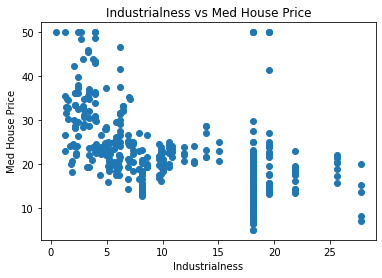

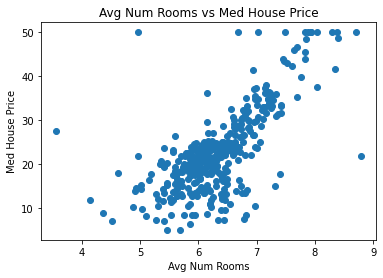

In [ ]:
from utils_function import scatter_plot

scatter_plot(train_X[:, 0], train_y,\
            title="Industrialness vs Med House Price",\
            x_label = "Industrialness",\
            y_label = "Med House Price")


scatter_plot(train_X[:, 1], train_y,\
            title="Avg Num Rooms vs Med House Price",\
            x_label = "Avg Num Rooms",\
            y_label = "Med House Price")

Hiên thời, vecto của ta đang có dạng như sau:

In [ ]:
print("Size of data X train matrix %s"  % str(train_X.shape))
print("Size of data Y train array %s"  % str(train_y.shape))
print("Size of data X test matrix %s"  % str(test_X.shape))
print("Size of data Y test array %s"  % str(test_y.shape))

Size of data X train matrix (404, 2)
Size of data Y train array (404,)
Size of data X test matrix (102, 2)
Size of data Y test array (102,)


In [ ]:
!pip install scikit-learn

#### Bài 1. Viết hàm cost function
$$J(w) = \frac{1}{m} \sum_{i=1}^m loss(\hat{y}^{(i)}, y^{(i)})= \frac{1}{2m} \sum_{i=1}^m (\hat{y}^{(i)}-y^{(i)})^2 $$
Khai triển, ta có kết quả:
$$J(w) = \frac{1}{2m} \sum_{i=1}^m (w_1 x_1^{(i)} + w_2 x_2^{(i)} + b - y^{(i)})^2 $$

#### 1.1. Viết chương trình

In [6]:
def np_cost(w, b, X, y):
    '''
    Evaluate the cost function in a non-vectorized manner for 
    inputs `X` and targets `y`, at weights `w` and `b`.
    
    X: 2D array dataset that has (m, n) dimension. 
    y: list of targets that has (n, ) dimension.
    w: list of weights that has (n, ) dimension
    b: a scalar bias.
    
    Return a scalar cost value of `w`, `b`.
    '''
    
    cost = 0
    m = X.shape[0]
    for i in range(m):
        
        # TODO: complete below expression to calculate cost function
        y_hat = w[0]*X[i, 0] + w[1]*X[i, 1] + b # hypothesis
        cost += (y_hat - y[i])**2 # sum cost of each data point.
        
    return cost/(2*m)

#### 1.2 Chạy thử chương trình 

In [7]:
np_cost([3, 5], 20, train_X, train_y) # 2256.1627893564355

NameError: name 'train_X' is not defined

In [ ]:
np_cost([3, 5], 0, train_X, train_y) # 1210.8142745049508

1210.8142745049508

#### Bài 2. Vector hóa hàm cost

Ngoài ra, ta còn có thể viết lại công thức trên như sau:

$$J(w) = \frac{1}{2m} \| X w + b  - y \| ^2$$ 

#### 2.1 Viết chương trình

In [ ]:
def np_cost_vectorized(w, b, X, y):
    '''
    Evaluate the cost function in a vectorized manner for 
    inputs `X` and targets `t`, at weights `w` and `b`.
    
    X: dataset matrix has (m, n) dimension. 
    y: targets vector has (n, ) dimension.
    w: weights vector has (n, ) dimension
    b: a scalar bias.
    
    Return a scalar cost value of `w`, `b`.
    '''
    
    #TODO: Complete the following expression
    m = X.shape[0] # number of samples in dataset
    w = np.array(w) # convert to numpy array
    y_hat = np.dot(X, w) + b# hypothesis
    
    return np.sum((y_hat - y)**2)/(2*m)

#### 2.2 Chạy thử chương trình

In [ ]:
np_cost_vectorized([3, 5], 20, train_X, train_y) # 2256.1627893564355

2256.1627893564355

In [ ]:
np_cost_vectorized([3, 5], 0, train_X, train_y) # 1210.8142745049508

1210.8142745049504

#### Bài 4.Tính vector gradient của w

Với $i = 1...m $ và $j = 1...n$ xét

$$ \frac{\partial J}{\partial w_j} = \frac{1}{m}\sum_{i=1}^m x_j^{(i)}(\hat{y}^{(i)}-y^{(i)}) $$



#### 4.1 Viết chương trình với vòng `for`

In [ ]:
def np_grad_fn(w, X, y):
    '''
    Given `w` - a current "Guess" of what our weights should be
          `X` - matrix of shape (m, n + 1) of input features
          `y` - target y values
    Return gradient of each weight evaluated at the current value
    '''
    
    #TODO: Complete the below followed the above expressions
    grad_w = np.zeros(np.array(w).shape)
    m = X.shape[0]
    y_hat = np.dot(X, w)
    for j in range(grad_w.shape[0]):
        for i in range(m):
            grad_w[j] += (y_hat[i] - y[i])*X[i, j]/m
    return grad_w

In [ ]:
w = [0.1, 0.2, 0.3]
np_grad_fn(w, train_X_new, train_y) #[-183.46936646, -130.26687224,  -19.93917772]

array([-183.46936646, -130.26687224,  -19.93917772])

#### 4.2 Write a program in vectorized form
$$\nabla J(w) = \frac{1}{m} X^T \left( Xw - y \right)$$ 

In [ ]:
def np_grad_fn_vectorized(w, X, y):
    '''
    Given `w` - a current "Guess" of what our weights should be
          `X` - matrix of shape (m, n + 1) of input features
          `y` - target y values
    Return gradient of each weight evaluated at the current value
    '''
    
    #TODO: Complete the below followed the above expressions
    m, n = X.shape
    y_hat = np.dot(X, w)
    grad_w = np.dot(X.T, y_hat - y)/m
    
    return grad_w

In [ ]:
w = [0.1, 0.2, 0.3]
np_grad_fn_vectorized(w, train_X_new, train_y) #[-183.46936646, -130.26687224,  -19.93917772]

array([-183.46936646, -130.26687224,  -19.93917772])

#### Bài  5. Tính dựa trên Gradient Descent

Xấp xỉ giá trị $w$ như sau

$$ w_j = w_j - \alpha * \frac{\partial J}{\partial w_j}$$

#### 5.1 Viết chương trình

In [ ]:
def np_solve_via_gradient_descent(X, y, print_every=5000,
                                  niter=100000, alpha=0.005):
    '''
    Given `X` - matrix of shape (m, n+1) of input features
          `y` - target y values
    Solves for linear regression weights.
    Return weights after `niter` iterations.
    '''
    m, n = X.shape
    # initialize all the weights to zeros
    w = np.zeros((n,))
    for k in range(niter):
        
        #TODO: Complete the below followed the above expressions
        dw = np_grad_fn_vectorized(w, X, y) 
        w = w - alpha*dw
        
        if k % print_every == 0:
            print('Weight after %d iteration: %s' % (k, str(w)))
    return w

#### 5.2 Chạy thử chương trình

In [ ]:
opt_w = np_solve_via_gradient_descent(train_X_new, train_y, niter=300000)

Weight after 0 iteration: [1.08841881 0.73504649 0.11305941]
Weight after 5000 iteration: [-0.52280011  5.12987932 -3.74261504]
Weight after 10000 iteration: [-0.49539334  5.64092276 -7.29776997]
Weight after 15000 iteration: [ -0.47316887   6.05533373 -10.18068575]
Weight after 20000 iteration: [ -0.4551468    6.39138431 -12.5184751 ]
Weight after 25000 iteration: [ -0.44053249   6.66389158 -14.41421522]
Weight after 30000 iteration: [ -0.42868158   6.88487083 -15.95149255]
Weight after 35000 iteration: [ -0.41907154   7.06406544 -17.19808831]
Weight after 40000 iteration: [ -0.41127866   7.20937639 -18.20896706]
Weight after 45000 iteration: [ -0.40495931   7.3272107  -19.02870019]
Weight after 50000 iteration: [ -0.39983489   7.42276389 -19.69343116]
Weight after 55000 iteration: [ -0.39567943   7.50024907 -20.2324691 ]
Weight after 60000 iteration: [ -0.39230972   7.56308268 -20.66958113]
Weight after 65000 iteration: [ -0.38957719   7.61403518 -21.02404027]
Weight after 70000 iter

In [ ]:
print("Training cost:", np_cost_vectorized(opt_w[:2], opt_w[2], train_X, train_y)) # 18.502043170574055

Training cost: 18.50204317057405


In [ ]:
print("Testing cost:", np_cost_vectorized(opt_w[:2], opt_w[2], test_X, test_y)) # 24.051240417619557

Testing cost: 24.05124041761955
